# Report

## Learning Algorithm 

This repository, specifically files below:
 - src/
     - dqn_agent.py
     - model.py 
     - replaybuffers.py

Contain implementation of Deep Q-Learning algorithm with following improvements:
    - Double Q-Learning
    - Prioretized Experience Replay
    
    

### Neural Network architecture 

File src/model.py contains PyTorch implementation of small Neural Network, that's used for Q function approximation as per Deep Q-Learning algorithm. 

``` python 
nn.Sequential(
            nn.Linear(state_size, layer_1_size),
            nn.ReLU(),
            nn.Linear(layer_1_size, layer_2_size),
            nn.ReLU(),
            nn.Linear(layer_2_size, layer_2_size),
            nn.ReLU(),
            nn.Linear(layer_2_size, action_size)
        )

```
As can be seen on code snipped above it's a fairly standard NN architecture with 2 hidden layers, built using fully connected layers (nn.Linear) with ReLU activations for all but output layer: 

- first Layer corresponds to Environment state_size which in case of Bannana collector is 37
- hidden layers have size of layer_1_size=64 and layer_2_size=128 neurons 
- output layer depends on environment action_size (equal to 4), so that this model can predict value of each action in single forward pass

The size and number of hidden layers was chosen experimentally. 

## Hyperparameters used

```python

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters               
LR = 1e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network


```


### NN Training
Network above is trained by minimizing [Mean Squared Error Loss function](https://pytorch.org/docs/stable/nn.html?highlight=mseloss#torch.nn.MSELoss) with help of [ADAM optimizer](https://pytorch.org/docs/stable/optim.html?highlight=mseloss#torch.optim.Adam). 

Learning rate of  LR = 1e-4  was chosen after some experimentation with values between (1e-2, 1e-5).


## Deep Q-Learning

DQN Agent is using 2 separate Neural Networks, both with identical architecture described above. They are used to implement Fixed Q-Targets, where one instance (qnetwork_local field in dqn_agent.py Agent class) instance is continuosly updated to minimize MSELoss (see NN Training) between Q values predicted by qnetwork_local and Q_targets calculated using [Deep Q-Learning Algorithm](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)

![alt text](https://github.com/nabacg/deep-rl-navigation-project/blob/master/images/DeepQLearningAlgo.png?raw=true "Deep Q-Learning Algo ")


### Double DQN 
[Double DQN] (https://arxiv.org/abs/1509.06461) is implemented inside src/dqn_agent.py Agent.learn method, relevant parts are copied below. Hopefully comments make it

```python


        ## Double Q-Learning implementation 
        # Find action with highest value using Q network under training (argmax on qnetwork_local) for each S'
        best_actions_by_local_nn = torch.max(self.qnetwork_local(next_states).detach(), dim=1)[1].unsqueeze(1)
        # Then use Target Q-network (one not trained atm) to predict Q values for each (S', best_action) pair, which hopefully should be less noisy than Qnetwork_local would predict
        action_values_by_target_nn = self.qnetwork_target(next_states).detach().gather(1, best_actions_by_local_nn)
        # once action_values are predicted using  
        Q_target = rewards + gamma * action_values_by_target_nn * (1 - dones)

        Q_pred = self.qnetwork_local(states).gather(1, actions)

        self.optimizer.zero_grad()
        loss = F.mse_loss(Q_pred, Q_target)

```


### Prioritized Experience Replay
Prioritized Experience Replay was implemented by replacing ReplayBuffer class (src/replaybuffers.py) with PrioretizedReplayBuffer class.  Main difference between them is that add method that saves experiences  into memory takes another td_error parameter which is then saved into buffer to be used for priority sampling. 

Sample method can subsequently use that priority to increase probability of selecting experiences that had higher TD error. Note this implementation is not very efficient 

```python
ps = [e.priority for e in self.memory if e is not None]
sum_ps = np.sum(ps)
experiences = random.choices(self.memory,
                                     weights=[e.priority / sum_ps for e in self.memory if e is not None],
                                     k = self.batch_size)

```

## Plot of Rewards

Plot from [Training](Training.ipynb) showing scores (total reword per episode) on agent trained from scratch until average score for 100 episode window reached 13.0. This was achived after 628 episodes, more details in Training notebook.

![alt text](https://github.com/nabacg/deep-rl-navigation-project/images/rewards_up_to_13.png " Scores 13 ")


The same algorithm when trained until mean target score of 17.5 is reached will produce following plot:

![alt text](https://github.com/nabacg/deep-rl-navigation-project/images/rewards_for_2000_episodes.png "Scores 17.5")




# Demo of testing pretrained agent 

with weight file qnetwork_model_weights_17_5.pth, which was trained until mean target score of 17.5 was reached. 

In [5]:
import sys
sys.path.append('src')
import os
from dqn_agent import Agent, train_agent, test_agent
from unityagents import UnityEnvironment

In [ ]:
env = UnityEnvironment(file_name="Banana.app")

In [7]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

In [11]:
scores = test_agent(agent, 
            env,
            input_weights= "qnetwork_model_weights_17_5.pth",
            n_episodes=100)

Episode 1\ Score: 14.00
Episode 2\ Score: 20.00
Episode 3\ Score: 20.00
Episode 4\ Score: 15.00
Episode 5\ Score: 14.00
Episode 6\ Score: 18.00
Episode 7\ Score: 21.00
Episode 8\ Score: 22.00
Episode 9\ Score: 16.00
Episode 10\ Score: 19.00
Episode 11\ Score: 7.00
Episode 12\ Score: 19.00
Episode 13\ Score: 17.00
Episode 14\ Score: 19.00
Episode 15\ Score: 14.00
Episode 16\ Score: 18.00
Episode 17\ Score: 22.00
Episode 18\ Score: 16.00
Episode 19\ Score: 14.00
Episode 20\ Score: 21.00
Episode 21\ Score: 14.00
Episode 22\ Score: 19.00
Episode 23\ Score: 16.00
Episode 24\ Score: 22.00
Episode 25\ Score: 21.00
Episode 26\ Score: 15.00
Episode 27\ Score: 23.00
Episode 28\ Score: 19.00
Episode 29\ Score: 19.00
Episode 30\ Score: 19.00
Episode 31\ Score: 13.00
Episode 32\ Score: 16.00
Episode 33\ Score: 18.00
Episode 34\ Score: 17.00
Episode 35\ Score: 22.00
Episode 36\ Score: 23.00
Episode 37\ Score: 21.00
Episode 38\ Score: 19.00
Episode 39\ Score: 18.00
Episode 40\ Score: 25.00
Episode 41

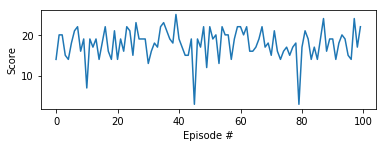

In [12]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

scores = scores
fig = plt.figure()
ax = fig.add_subplot(212)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Ideas for Future Work
- implement Dueling DQN and/or Rainbow 
- more performant implementation of Prioretized Experience Replay
- learning from pixels